## Making a Lightcurve from PTF catalog data

In [18]:
from __future__ import division
import numpy as np
import astropy.io.fits as fits
import astropy.coordinates as coords
import astropy.units as u
from astropy.time import Time
from glob import glob
import matplotlib.pyplot as plt
import shelve, pickle
import uuid
from IPython.display import HTML, Javascript, display
import time
%matplotlib inline

In [2]:
reference_catalog = '../data/PTF_Refims_Files/PTF_d022683_f02_c06_u000114210_p12_sexcat.ctlg'
# select R-band data (f02)
epoch_catalogs = glob('../data/PTF_Procim_Files/PTF*f02*.ctlg')

In [10]:
len(epoch_catalogs)

72

In [3]:
def load_ref_catalog(reference_catalog):
    hdus = fits.open(reference_catalog)
    data = hdus[1].data
    # filter flagged detections
    w = (data['flags'] & 506 == 0)
    data = data[w]

    ref_coords = coords.SkyCoord(data['X_WORLD'], data['Y_WORLD'],frame='icrs',unit='deg')

    return np.vstack([data['MAG_AUTO'],data['MAGERR_AUTO']]).T, ref_coords

In [4]:
ref_mags, ref_coords = load_ref_catalog(reference_catalog)

In [94]:
len(ref_mags)

14043

In [5]:
# optional: progress bar
def load_progress_bar():
    divid = str(uuid.uuid4())
    pb = HTML(
"""
<div style="border: 1px solid black; width:500px">
  <div id="%s" style="background-color:blue; width:0%%">&nbsp;</div>
</div> 
""" % divid)
    display(pb)
    return divid

In [7]:
def crossmatch_epochs(reference_coords, epoch_catalogs):
    
    n_stars = len(reference_coords)
    n_epochs = len(epoch_catalogs)
    
    mags = np.ma.zeros([n_stars, n_epochs])
    magerrs = np.ma.zeros([n_stars, n_epochs])
    mjds = np.ma.zeros(n_epochs)
    
    divid = load_progress_bar()
    for i, catalog in enumerate(epoch_catalogs):
        #print catalog
        hdus = fits.open(catalog)
        data = hdus[1].data
        hdr = hdus[2].header
        # filter flagged detections
        w = ((data['flags'] & 506 == 0) & (data['imaflags_iso'] & 1821 == 0))
        data = data[w]

        epoch_coords = coords.SkyCoord(data['X_WORLD'], data['Y_WORLD'],frame='icrs',unit='deg')
        idx, sep, dist = coords.match_coordinates_sky(epoch_coords, reference_coords)
        
        wmatch = (sep <= 1.5*u.arcsec)
        
        # store data
        if np.sum(wmatch):
            mags[idx[wmatch],i] = data[wmatch]['MAG_AUTO'] + data[wmatch]['ZEROPOINT']
            magerrs[idx[wmatch],i] = data[wmatch]['MAGERR_AUTO']
            mjds[i] = hdr['OBSMJD']

        display(Javascript("$('div#%s').width('%i%%')" % (divid, int((i+1)/n_epochs*100))))
    return mjds, mags, magerrs

In [8]:
mjds,mags,magerrs = crossmatch_epochs(ref_coords, epoch_catalogs)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# mask obviously bad mags
wbad = (mags < 10) | (mags > 25)
mags[wbad] = np.ma.masked
magerrs[wbad] = np.ma.masked

<Container object of 3 artists>

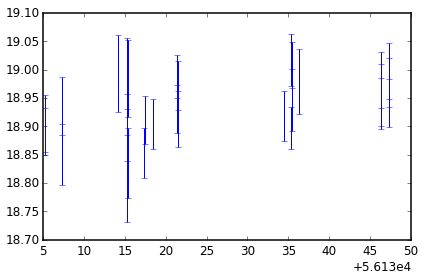

In [11]:
source_idx = 14
plt.errorbar(mjds, mags[source_idx,:],magerrs[source_idx,:],fmt='none')

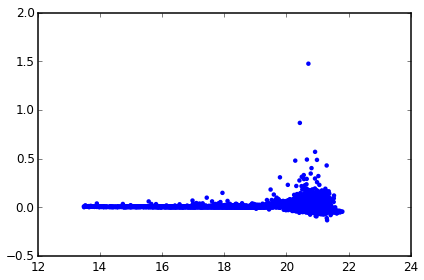

In [12]:
plt.scatter(np.ma.median(mags,axis=1), np.ma.std(mags,axis=1)**2. - np.ma.mean(magerrs**2.,axis=1))

In [13]:
def relative_photometry(mags, magerrs):
    #make copies, as we're going to modify the masks
    all_mags = mags.copy()
    all_errs = magerrs.copy()
    
    # average over observations
    medmags = np.ma.median(all_mags,axis=1)
    stdmags = np.ma.std(all_mags,axis=1)
    MSE = np.ma.mean(all_errs**2.,axis=1)

    # exclude bad stars: highly variable, saturated, or faint
    # use excess variance to find bad objects
    excess_variance = stdmags**2. - MSE
    wbad = np.where((np.abs(excess_variance) > 0.3) | (medmags < 14.5) | (medmags > 19))
    # mask them out
    medmags[wbad] = np.ma.masked

    # for each observation, take the median of the difference between the median mag and the observed mag
    # annoying dimension swapping to get the 1D vector to blow up right
    relative_zp = np.ma.median(all_mags - np.ma.resize(medmags,(all_mags.shape[1],all_mags.shape[0])).T,axis=0)

    return relative_zp

In [14]:
# compute the relative photometry and subtract it. Don't fret about error propagation
rel_zp = relative_photometry(mags, magerrs)
mags -= np.ma.resize(rel_zp, mags.shape)

<Container object of 3 artists>

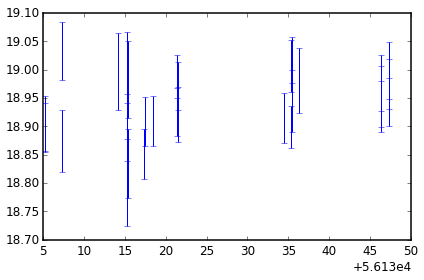

In [15]:
source_idx = 14
plt.errorbar(mjds, mags[source_idx,:],magerrs[source_idx,:],fmt='none')

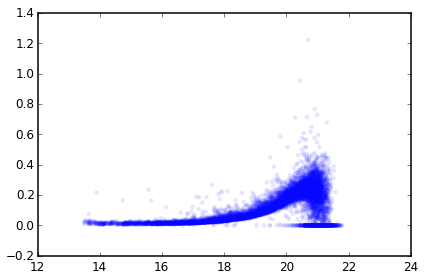

In [203]:
plt.scatter(np.ma.median(mags,axis=1), np.ma.std(mags,axis=1),alpha=0.1)

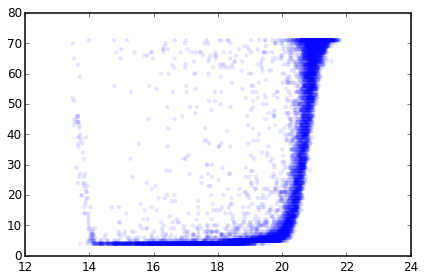

In [204]:
plt.scatter(np.ma.median(mags,axis=1), np.ma.sum(mags.mask,axis=1),alpha=0.1)

In [21]:
# save the output: ref_coords, mjds, mags, magerrs.

outfile = reference_catalog.split('/')[-1].replace('ctlg','shlv')
shelf = shelve.open('../data/'+outfile,flag='c',protocol=pickle.HIGHEST_PROTOCOL)
shelf['ref_coords'] = ref_coords
shelf['mjds'] = mjds
shelf['mags'] = mags
shelf['magerrs'] = magerrs
shelf.close()

In [25]:
# demonstrate getting the data back out
shelf = shelve.open('../data/'+outfile)
for key in shelf.keys():
    print key, shelf[key].shape
shelf.close()

mags (14043, 72)
mjds (72,)
ref_coords (14043,)
magerrs (14043, 72)
